# PCA

## 1. 降维和PCA

PCA即主成分分析(Principal Component Analysis)，要理解PCA，首先要理解一个更广义的概念：降维。

降维即降低数据集的维度，这里的维度指的是输入变量或者特征的数量。机器学习算法要求输入是大小为(n_samples, n_features)的二维矩阵(类似excel表格)，n_samples是观测值的数量(行)，n_features是特征的数量(列)。

当数据集包含很多特征时，例如100个，如果把所有数据全部喂入模型，可能会导致糟糕的结果。在高维数据集中，往往只有部分特征有良好的预测能力，很多特征纯粹是噪音(没有预测能力)，很多特征彼此之间也可能高度相关，这些因素会降低模型的预测精度，训练模型的时间也更长。降低数据集的维度在某种程度上能解决这些问题。

降维算法的原理是通过捕捉特征之间的关联，创建新的特征来代替旧的特征，降维后的数据集要求保留原始数据的大部分变异。

PCA是最广泛使用的降维技术之一，它把大量的相关变量转化为几组无关变量，这些无关变量称为"主成分"。原理如下图所示。

![pca](../pic/pca.png)

下方的数学公式能帮助我们更好地理解PCA。假设数据集有10个特征：$X_1, X_2, X_3, X_4, ..., X_{10}$，通过PCA将维度降低到2，创建两个主成分。

$$C_1 = a_1*X_1 + a_2*X_2 + a_3*X_3 + a_4*X_4 + ... + a_{10}*X_{10}$$
$$C_2 = b_1*X_1 + b_2*X_2 + b_3*X_3 + b_4*X_4 + ... + b_{10}*X_{10}$$

$C_1, C_2$是主成分，$a_i, b_i$是加权因子，所以主成分是特征的线性组合。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use("ggplot")

## 2. 虚拟数据集

先创建一个虚拟数据集，使用make_classification实现，假设有1000个观测值，50个特征（只有10个有预测作用），目标变量包含两个类别。

In [3]:
X, y = make_classification(
    n_samples=1000,  # 1000个观测值
    n_features=50,  # 50个特征
    n_informative=10,  # 只有10个特征有预测能力
    n_redundant=40,  # 40个冗余的特征
    n_classes=2,  # 目标变量包含两个类别
    random_state=123  # 随机数种子，保证可重复结果
)

## 3. 用Sklearn实现PCA

针对不同类型的数据集，sklearn提供了不同的实现算法，最常用的接口是PCA类。

关于更复杂接口的讨论，请参阅[官方文档](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca)。

拟合PCA模型前要先选择约简维数，即主成分个数，为简单起见先选择5。

In [4]:
# 创建PCA对象，声明主成分个数
pca = PCA(n_components=5)

# 拟合数据
res = pca.fit_transform(X)

print("original shape: ", X.shape)
print("transformed shape: ", res.shape)

original shape:  (1000, 50)
transformed shape:  (1000, 5)


调用pca.fit_transform得到一个n维数组，每一列代表一个"主成分"，它们是原始特征的线性组合。

第一个主成分对原始数据的变异（方差）解释最大，第二个主成分与第一个主成分正交（无相关关系），它包含了剩余变异的大部分，第三个主成分与前两个主成分正交，并包含剩余变异的大部分，以此类推。

In [5]:
res[:10, :3]

array([[-1.06911130e+01, -1.13129246e+01, -7.68090419e+00],
       [ 1.51167657e+01, -5.55132195e+00, -3.92910293e+00],
       [-1.46211542e+01, -2.88266661e+00, -9.54266594e+00],
       [-1.01355685e+01,  3.00902686e+01, -7.92117767e+00],
       [ 1.74994045e+01, -3.82728356e-03, -1.44630929e+01],
       [-1.93077317e+01, -3.51322250e-01,  7.92855260e+00],
       [ 9.49278994e+00,  1.26887973e+01, -3.82387627e+00],
       [ 5.06730328e+00,  1.12799582e+01, -7.11046900e+00],
       [ 1.41771036e+01, -5.95236689e+00,  1.17335990e+00],
       [-2.99632207e+00,  5.50119352e+00, -4.05459848e+00]])

用散点图查看主成分的关系，它们是线性无关的。

Text(0, 0.5, 'Second Main Component')

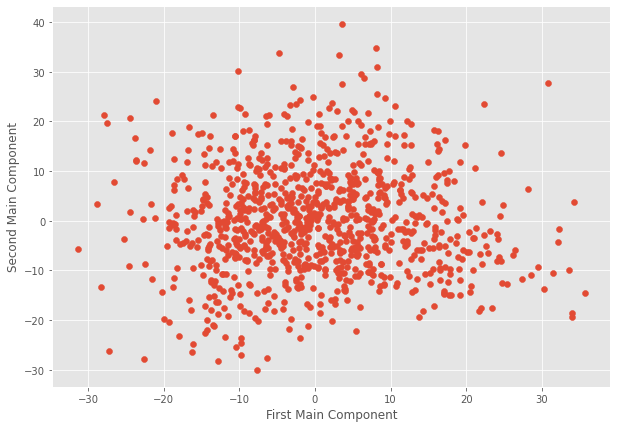

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(res[:, 0], res[:, 1])
ax.set_xlabel("First Main Component")
ax.set_ylabel("Second Main Component")

主成分保留了原始数据集的大部分变异，可以从res.explained_variance_ratio_这个属性获取所有主成分对原始数据方差的解释比率。

In [7]:
var_ratio = pca.explained_variance_ratio_

for idx, val in enumerate(var_ratio, 1):
    print("Principle component %d: %.2f%%" % (idx, val * 100))
print("total: %.2f%%" % np.sum(var_ratio * 100))

Principle component 1: 22.13%
Principle component 2: 19.80%
Principle component 3: 14.47%
Principle component 4: 12.72%
Principle component 5: 9.68%
total: 78.80%


## 4. 选择主成分个数

当主成分个数等于5，仅仅保留了原始变异的78.8%，这显然是不够的，那么如何正确地选择主成分的个数？

可以用数据挖掘，尝试不同的主成分个数，获得相应的累计解释方差比率，选择令人满意的临界点。

Text(0, 0.5, 'explained variance ratio(%)')

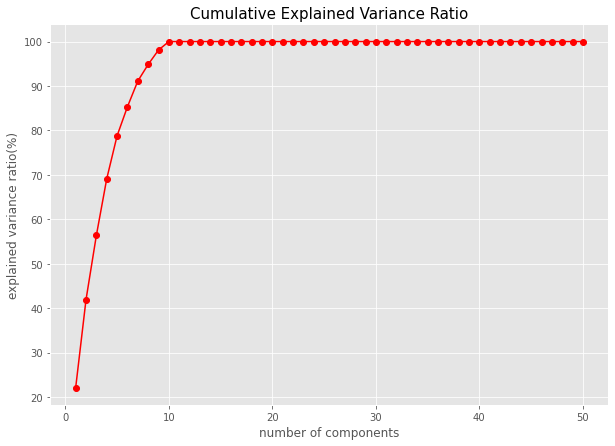

In [8]:
# n_components=None, 主成分个数默认等于特征数量
pca = PCA(n_components=None)

# 拟合数据
pca.fit(X)

# 获取解释方差比率
evr = pca.explained_variance_ratio_ * 100

# 查看累计解释方差比率与主成分个数的关系
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(1, len(evr) + 1), np.cumsum(evr), "-ro")
ax.set_title("Cumulative Explained Variance Ratio", fontsize=15)
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio(%)")

上图显示，当主成分个数=7，累计解释方差比例达到90%，主成分个数=10，累计解释方差比例达到100%。

另一种更简单的办法是，设定累计解释方差比率的目标，让sklearn自动选择最优的主成分个数。

In [9]:
target = 0.9  # 保留原始数据集90%的变异
res = PCA(n_components=target).fit_transform(X)

print("original shape: ", X.shape)
print("transformed shape: ", res.shape)

original shape:  (1000, 50)
transformed shape:  (1000, 7)


## 5. 结论

我们学习了两个重要的概念：降维，PCA，以及如何用python sklearn实现PCA。

在这个简单的案例中，我们看到了PCA降维的作用，仅仅创建7-8个新"特征"，就足以替代包含50个特征的原始数据集。在训练模型阶段，这将大大减少训练的时间。但PCA并不完美，由于主成分是原始特征的线性组合，它们缺乏真实的特征所具备的经济意义，这是PCA最大的缺点之一。